In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer

In [4]:
movies = pd.read_csv("data/movies.csv")
ratings = pd.read_csv("data/ratings.csv")
tags = pd.read_csv("data/tags.csv")

In [5]:
print(movies.shape)
print(ratings.shape)
print(tags.shape)

(64688, 3)
(84658, 4)
(90162, 4)


In [6]:
print(movies.head())
print(ratings.head())
print(tags.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858
   userId   movieId          tag     timestamp
0      22   26479.0  Kevin Kline  1.583039e+09
1      22   79592.0     misogyny  1.581476e+09
2      22  247150.0   acrophobia  1.

In [7]:
merged = ratings.merge(movies, on="movieId", how="left")
print(merged.shape)

(84724, 6)


When working with MovieLens 32M or even the 10M dataset, I noticed that the volume was too large for Google Colab’s memory. I chose to subset the dataset so I can still test my pipeline without crashing the runtime.
To preserve the distribution of ratings, we sample a fraction of rows

In [8]:
# Keep 10% of the dataset
ratings_subset = ratings.sample(frac=0.1, random_state=42)

# Merge with movies
merged_subset = ratings_subset.merge(movies, on="movieId", how="left")
print(merged_subset.shape)

(8473, 6)


## EDA

### 1. Distribution of ratings

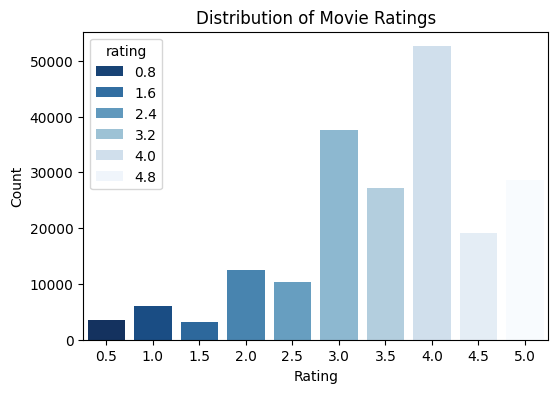

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=merged_subset, palette="Blues_r", hue="rating")
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

### 2. Ratings per User

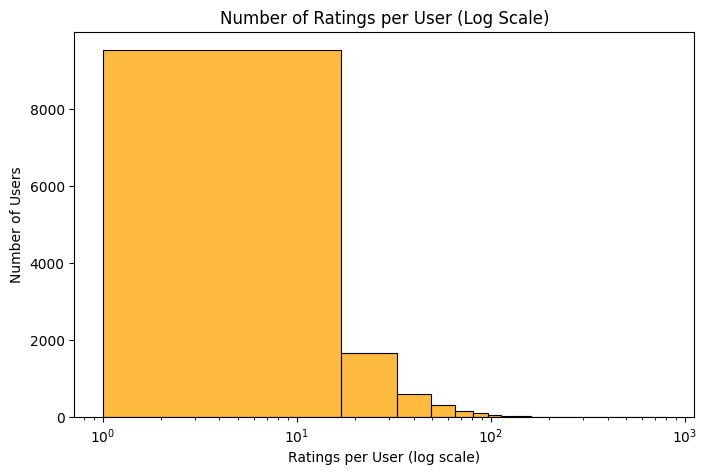

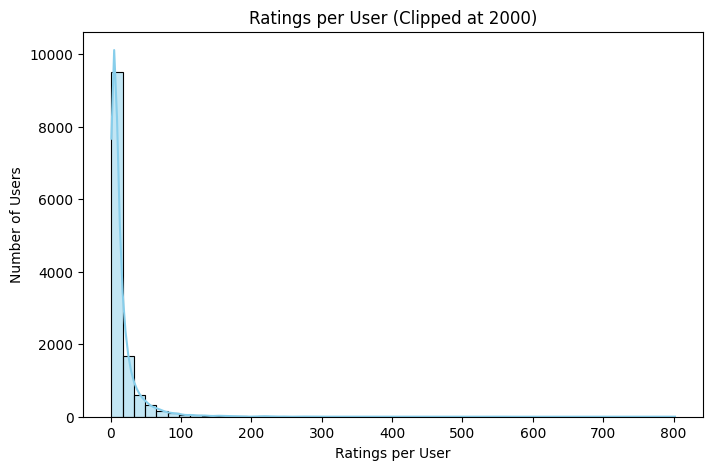

User Ratings per User - Summary:
count    12589.000000
mean        15.959647
std         28.809477
min          1.000000
25%          4.000000
50%          7.000000
75%         17.000000
90%         36.000000
95%         56.000000
99%        130.000000
max        802.000000
Name: rating, dtype: float64


In [10]:
ratings_per_user = merged_subset.groupby("userId")["rating"].count()

# The ratings per user chart is not very useful because a few “power users” rate thousands of movies,
# which skews the distribution. We can make it clearer by Log-scaling the x-axis
plt.figure(figsize=(8,5))
sns.histplot(ratings_per_user, bins=50, color="orange", edgecolor="black")
plt.xscale("log")  # log scale makes skew clearer
plt.title("Number of Ratings per User (Log Scale)")
plt.xlabel("Ratings per User (log scale)")
plt.ylabel("Number of Users")
plt.show()

# We can also Clip outliers and limit it to users who have < 2000 ratings)
plt.figure(figsize=(8,5))
sns.histplot(ratings_per_user[ratings_per_user < 2000], bins=50, color="skyblue", kde=True)
plt.title("Ratings per User (Clipped at 2000)")
plt.xlabel("Ratings per User")
plt.ylabel("Number of Users")
plt.show()

# Print descriptive stats
print("User Ratings per User - Summary:")
print(ratings_per_user.describe(percentiles=[.25,.5,.75,.9,.95,.99]))

### 3. Identify Top users and their preferences

In [11]:
# Count ratings per user
ratings_per_user = ratings.groupby("userId")["movieId"].count().sort_values(ascending=False)

# Top 5 users by rating activity
top_users = ratings_per_user.head(5).index.tolist()
print("Top 5 Users:", top_users)

# For each top user, show their top 5 rated movies
for user in top_users:
    user_ratings = merged[merged["userId"] == user]
    favorites = user_ratings.sort_values(by="rating", ascending=False).head(5)

    print(f"\nUser {user} - Top Rated Movies:")
    print(favorites[["title", "rating"]])


Top 5 Users: [10202, 7858, 8588, 8359, 9085]

User 10202 - Top Rated Movies:
                            title  rating
1596144   Dead Man Walking (1995)     5.0
1596135            Othello (1995)     5.0
1596113          Toy Story (1995)     5.0
1596134  Leaving Las Vegas (1995)     5.0
1596130         Get Shorty (1995)     5.0

User 7858 - Top Rated Movies:
                                                     title  rating
1213199                                        Babe (1995)     5.0
1213169                                   Toy Story (1995)     5.0
1216828                          Brokeback Mountain (2005)     5.0
1218727             Drew: The Man Behind the Poster (2013)     5.0
1218722  Patton Oswalt: Tragedy Plus Comedy Equals Time...     5.0

User 8588 - Top Rated Movies:
                                                     title  rating
1341158                                 Phantasm II (1988)     5.0
1341187                         Way of the Gun, The (2000)     5.0
134118

### 4. Average Rating by Genre

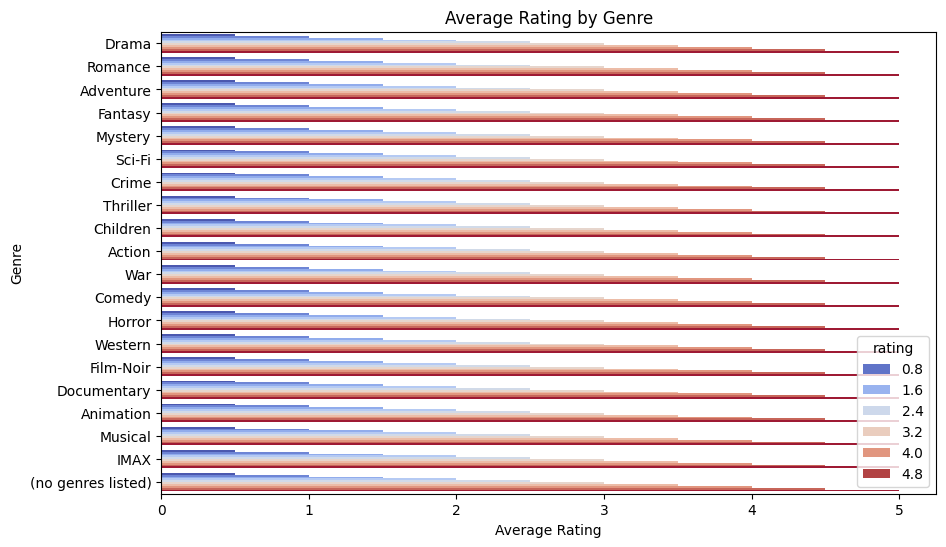

In [15]:
# Split genres into multiple rows
genres_exploded = merged_subset.assign(genre=merged["genres"].str.split("|")).explode("genre")

plt.figure(figsize=(10,6))
sns.barplot(x="rating", y="genre", data=genres_exploded, errorbar=None, palette="coolwarm", hue="rating")
plt.title("Average Rating by Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()


### 5. Most common genres

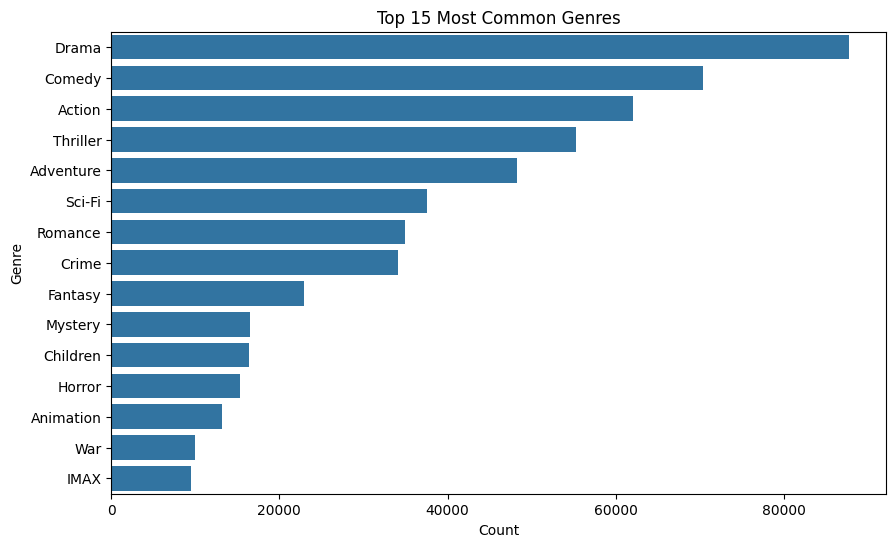

In [18]:
genre_counts = genres_exploded["genre"].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title("Top 15 Most Common Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


### 6. Most Frequent Tags

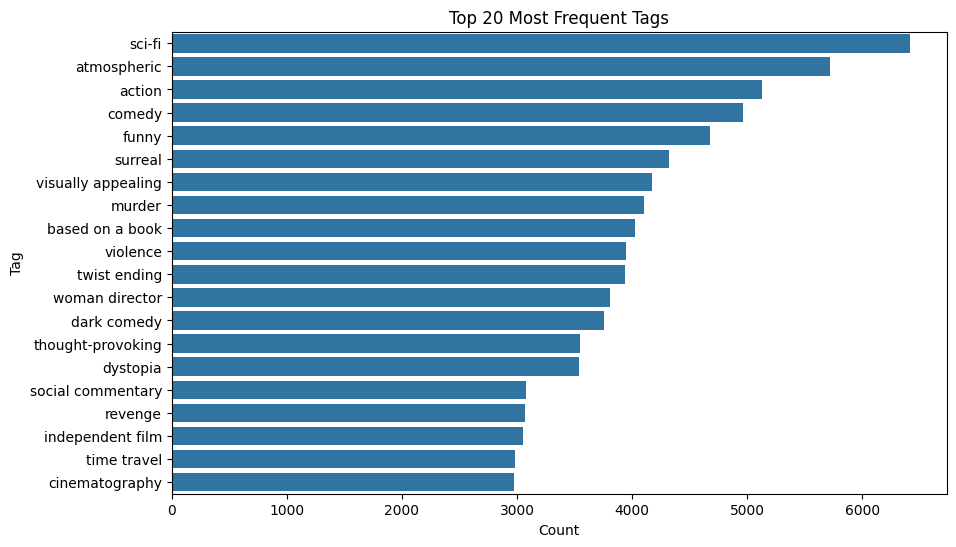

In [20]:
top_tags = tags["tag"].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_tags.values, y=top_tags.index)
plt.title("Top 20 Most Frequent Tags")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.show()


### 7. Tag Usage over time

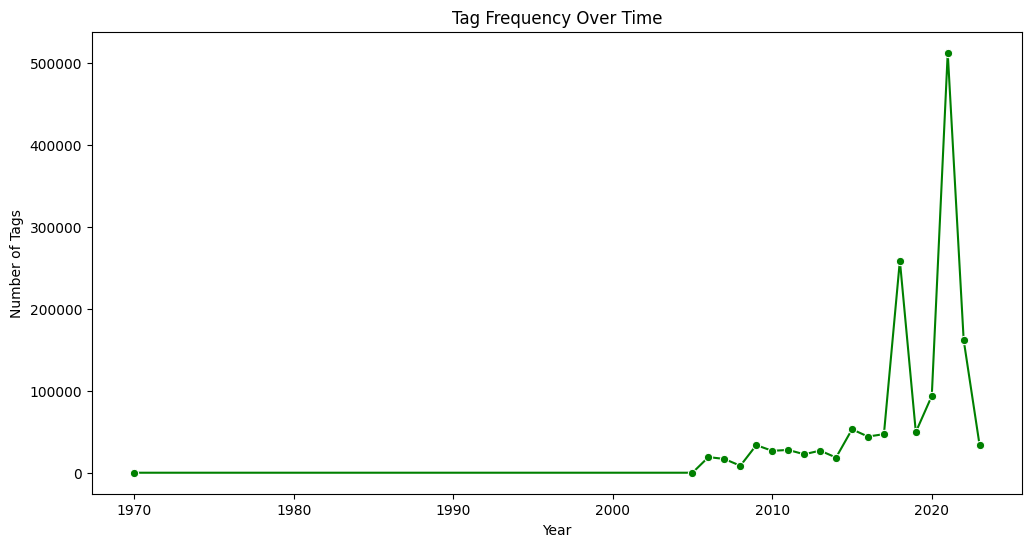

In [21]:
tags["year"] = pd.to_datetime(tags["timestamp"], unit="s").dt.year
tags_per_year = tags.groupby("year")["tag"].count()

plt.figure(figsize=(12,6))
sns.lineplot(x=tags_per_year.index, y=tags_per_year.values, marker="o", color="green")
plt.title("Tag Frequency Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Tags")
plt.show()


## Baseline modal - Linear Regression

In [11]:
# Feature engineering
user_means = merged_subset.groupby("userId")["rating"].mean()
movie_means = merged_subset.groupby("movieId")["rating"].mean()

merged_subset["user_mean"] = merged_subset["userId"].map(user_means)
merged_subset["movie_mean"] = merged_subset["movieId"].map(movie_means)

# One-hot encode genres
genre_dummies = merged_subset["genres"].str.get_dummies(sep="|")
features = pd.concat([merged_subset[["user_mean", "movie_mean"]], genre_dummies], axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(features, merged_subset["rating"], test_size=0.2, random_state=42)

# Train linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_pred = linreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("RMSE:", rmse)


RMSE: 0.6634259670628146


### Use tags as features

In [12]:
movie_ids = ratings_subset["movieId"].unique()
movies_subset = movies[movies["movieId"].isin(movie_ids)].copy()

tags_subset = tags[tags["movieId"].isin(movie_ids)].copy()
tags_subset["movieId"] = tags_subset["movieId"].astype(int)

tags_subset["tag"] = tags_subset["tag"].astype(str)

print(tags_subset.shape)

tag_text_by_movie = (
    tags_subset.groupby("movieId")["tag"]
    .apply(lambda s: " ".join([t for t in s if t.strip() != ""]))
    .reset_index()
    .rename(columns={"tag": "tag_text"})
)

#print(tag_text_by_movie.head())

merged_with_tags = merged_subset.merge(tag_text_by_movie, on="movieId", how="left")
#print(merged_with_tags.head())
merged_with_tags["tag_text"] = merged_with_tags["tag_text"].fillna("").astype(str)


#print("Has tag_text?", "tag_text" in merged_with_tags.columns, "| empty rows:", (merged_with_tags["tag_text"] == "").sum())
#print("Columns now:", list(merged_with_tags.columns))

# Feature blocks
numeric_features = ["user_mean", "movie_mean"]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
])

for c in ["tag_text", "genres"]:
    if c in merged_with_tags.columns:
        merged_with_tags[c] = merged_with_tags[c].astype(str)
        merged_with_tags.loc[
            merged_with_tags[c].str.lower().isin(["nan", "none", "na"]), c
        ] = ""
    else:
        merged_with_tags[c] = ""

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_features),
        ("genres", OneHotEncoder(handle_unknown="ignore"), ["genres"]),
        ("tags", TfidfVectorizer(max_features=1000, ngram_range=(1,1)), "tag_text")
    ]
)

pipe = Pipeline([
    ("features", preprocessor),
    ("model", Ridge(alpha=5.0))  # ridge helps with many TF-IDF features
])



X = merged_with_tags[["genres", "tag_text"] + numeric_features]
y = merged_with_tags["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)


# Predictions
y_pred = pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("RMSE for Linear Regression with Tags:", rmse)

(58448, 4)
RMSE for Linear Regression with Tags: 0.7031110502356626
